In [1]:
import osmnx as ox
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from dataclasses import dataclass
from typing import List, Dict, Tuple
import networkx as nx

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Bucket:
    id: int
    center_lat: float
    center_lon: float
    node_count: int
    nodes: List[int]
    bbox: Tuple[float, float, float, float]

def split_graph_into_buckets_network_distance(G: nx.Graph, n_buckets: int = 10) -> List[Bucket]:
    # Extract node data
    node_ids = list(G.nodes())
    node_id_to_index = {node_id: idx for idx, node_id in enumerate(node_ids)}
    index_to_node_id = {idx: node_id for node_id, idx in node_id_to_index.items()}
    node_positions = np.array([[G.nodes[node]['y'], G.nodes[node]['x']] for node in node_ids])
    
    # Compute shortest path lengths between all pairs (sparse)
    length_dict = dict(nx.all_pairs_dijkstra_path_length(G, weight='length'))
    
    # Create full distance matrix
    n = len(node_ids)
    dist_matrix = np.full((n, n), np.inf)
    
    for i, source_id in enumerate(node_ids):
        for target_id, dist in length_dict[source_id].items():
            j = node_id_to_index[target_id]
            dist_matrix[i][j] = dist

    # Replace infinite distances (unreachable) with large number
    unreachable_distance = np.nanmax(dist_matrix[dist_matrix < np.inf]) * 2
    dist_matrix[dist_matrix == np.inf] = unreachable_distance

    # Clustering using network distance (with updated parameter)
    clustering = AgglomerativeClustering(
        n_clusters=n_buckets,
        metric='precomputed',
        linkage='average'
    )
    cluster_labels = clustering.fit_predict(dist_matrix)

    # Build DataFrame for cluster assignment
    df = pd.DataFrame({
        'node_id': node_ids,
        'lat': node_positions[:, 0],
        'lon': node_positions[:, 1],
        'cluster': cluster_labels
    })

    # Build buckets
    buckets = []
    for i in range(n_buckets):
        cluster_nodes = df[df['cluster'] == i]
        if cluster_nodes.empty:
            continue
        center_lat = cluster_nodes['lat'].mean()
        center_lon = cluster_nodes['lon'].mean()
        min_lat, max_lat = cluster_nodes['lat'].min(), cluster_nodes['lat'].max()
        min_lon, max_lon = cluster_nodes['lon'].min(), cluster_nodes['lon'].max()
        
        bucket = Bucket(
            id=i,
            center_lat=center_lat,
            center_lon=center_lon,
            node_count=len(cluster_nodes),
            nodes=cluster_nodes['node_id'].tolist(),
            bbox=(min_lat, min_lon, max_lat, max_lon)
        )
        buckets.append(bucket)
    
    return buckets


def visualize_buckets(
    G: nx.Graph,
    buckets: List[Bucket],
    save_path: str = './cls.png',
    max_buckets_to_plot: int = 4999,
    show_nodes: bool = True,
):
    try:
        import matplotlib.pyplot as plt
        import matplotlib.colors as mcolors
    except ImportError:
        print("matplotlib required for visualization")
        return

    fig, ax = ox.plot_graph(
        G,
        show=False,
        close=False,
        figsize=(100, 100),  # <-- set to a larger width x height in inches
        node_size=0,
        edge_color='lightgray',
        edge_linewidth=0.5
    )

    total_buckets = len(buckets)
    buckets_to_plot = buckets[:max_buckets_to_plot] if total_buckets > max_buckets_to_plot else buckets

    colors = list(mcolors.TABLEAU_COLORS.values())
    if len(buckets_to_plot) > len(colors):
        colors = colors * (len(buckets_to_plot) // len(colors) + 1)

    for i, bucket in enumerate(buckets_to_plot):
        color = colors[i]
        if show_nodes and bucket.nodes:
            node_lats = [G.nodes[n]['y'] for n in bucket.nodes]
            node_lons = [G.nodes[n]['x'] for n in bucket.nodes]

            ax.scatter(node_lons, node_lats, c=color, s=10, alpha=0.8)

        # Always plot bucket center
        ax.scatter(
            bucket.center_lon, bucket.center_lat,
            c='red', s=20, marker='x', linewidths=1.5, zorder=3
        )

    title = f"Graph Buckets ({total_buckets} total, showing {len(buckets_to_plot)})"

    plt.title(title)


    plt.show()


In [9]:
# Load the graph
place = "Savojbolagh County, Alborz Province, Iran"
G = ox.graph_from_place(place, network_type='walk')

# Create buckets using different methods
print("Creating buckets using K-means clustering...")
# kmeans_buckets = split_graph_into_buckets_network_distance(G, n_buckets=500)


import pickle
# with open('buckets2.pkl', 'wb') as f:
#     pickle.dump(kmeans_buckets, f)
# buckets_data = [b.__dict__ for b in kmeans_buckets]
# with open("buckets0_data.pkl", "wb") as f:
#     pickle.dump(buckets_data, f)

with open("buckets1_data.pkl", "rb") as f:
    buckets_data = pickle.load(f)
def buckets_from_dicts(dict_list: List[dict]) -> List[Bucket]:
    return [Bucket(**b) for b in dict_list]
kmeans_buckets = buckets_from_dicts(buckets_data)


# with open('buckets2.pkl', 'rb') as f:
#     kmeans_buckets = pickle.load(f)

Creating buckets using K-means clustering...


In [10]:
len(kmeans_buckets)

1000

In [4]:
# import pickle

# with open('buckets.pkl', 'rb') as f:
#     kmeans_buckets = pickle.load(f)
# buckets_data = [b.__dict__ for b in kmeans_buckets]
# with open("buckets1_data.pkl", "wb") as f:
#     pickle.dump(buckets_data, f)

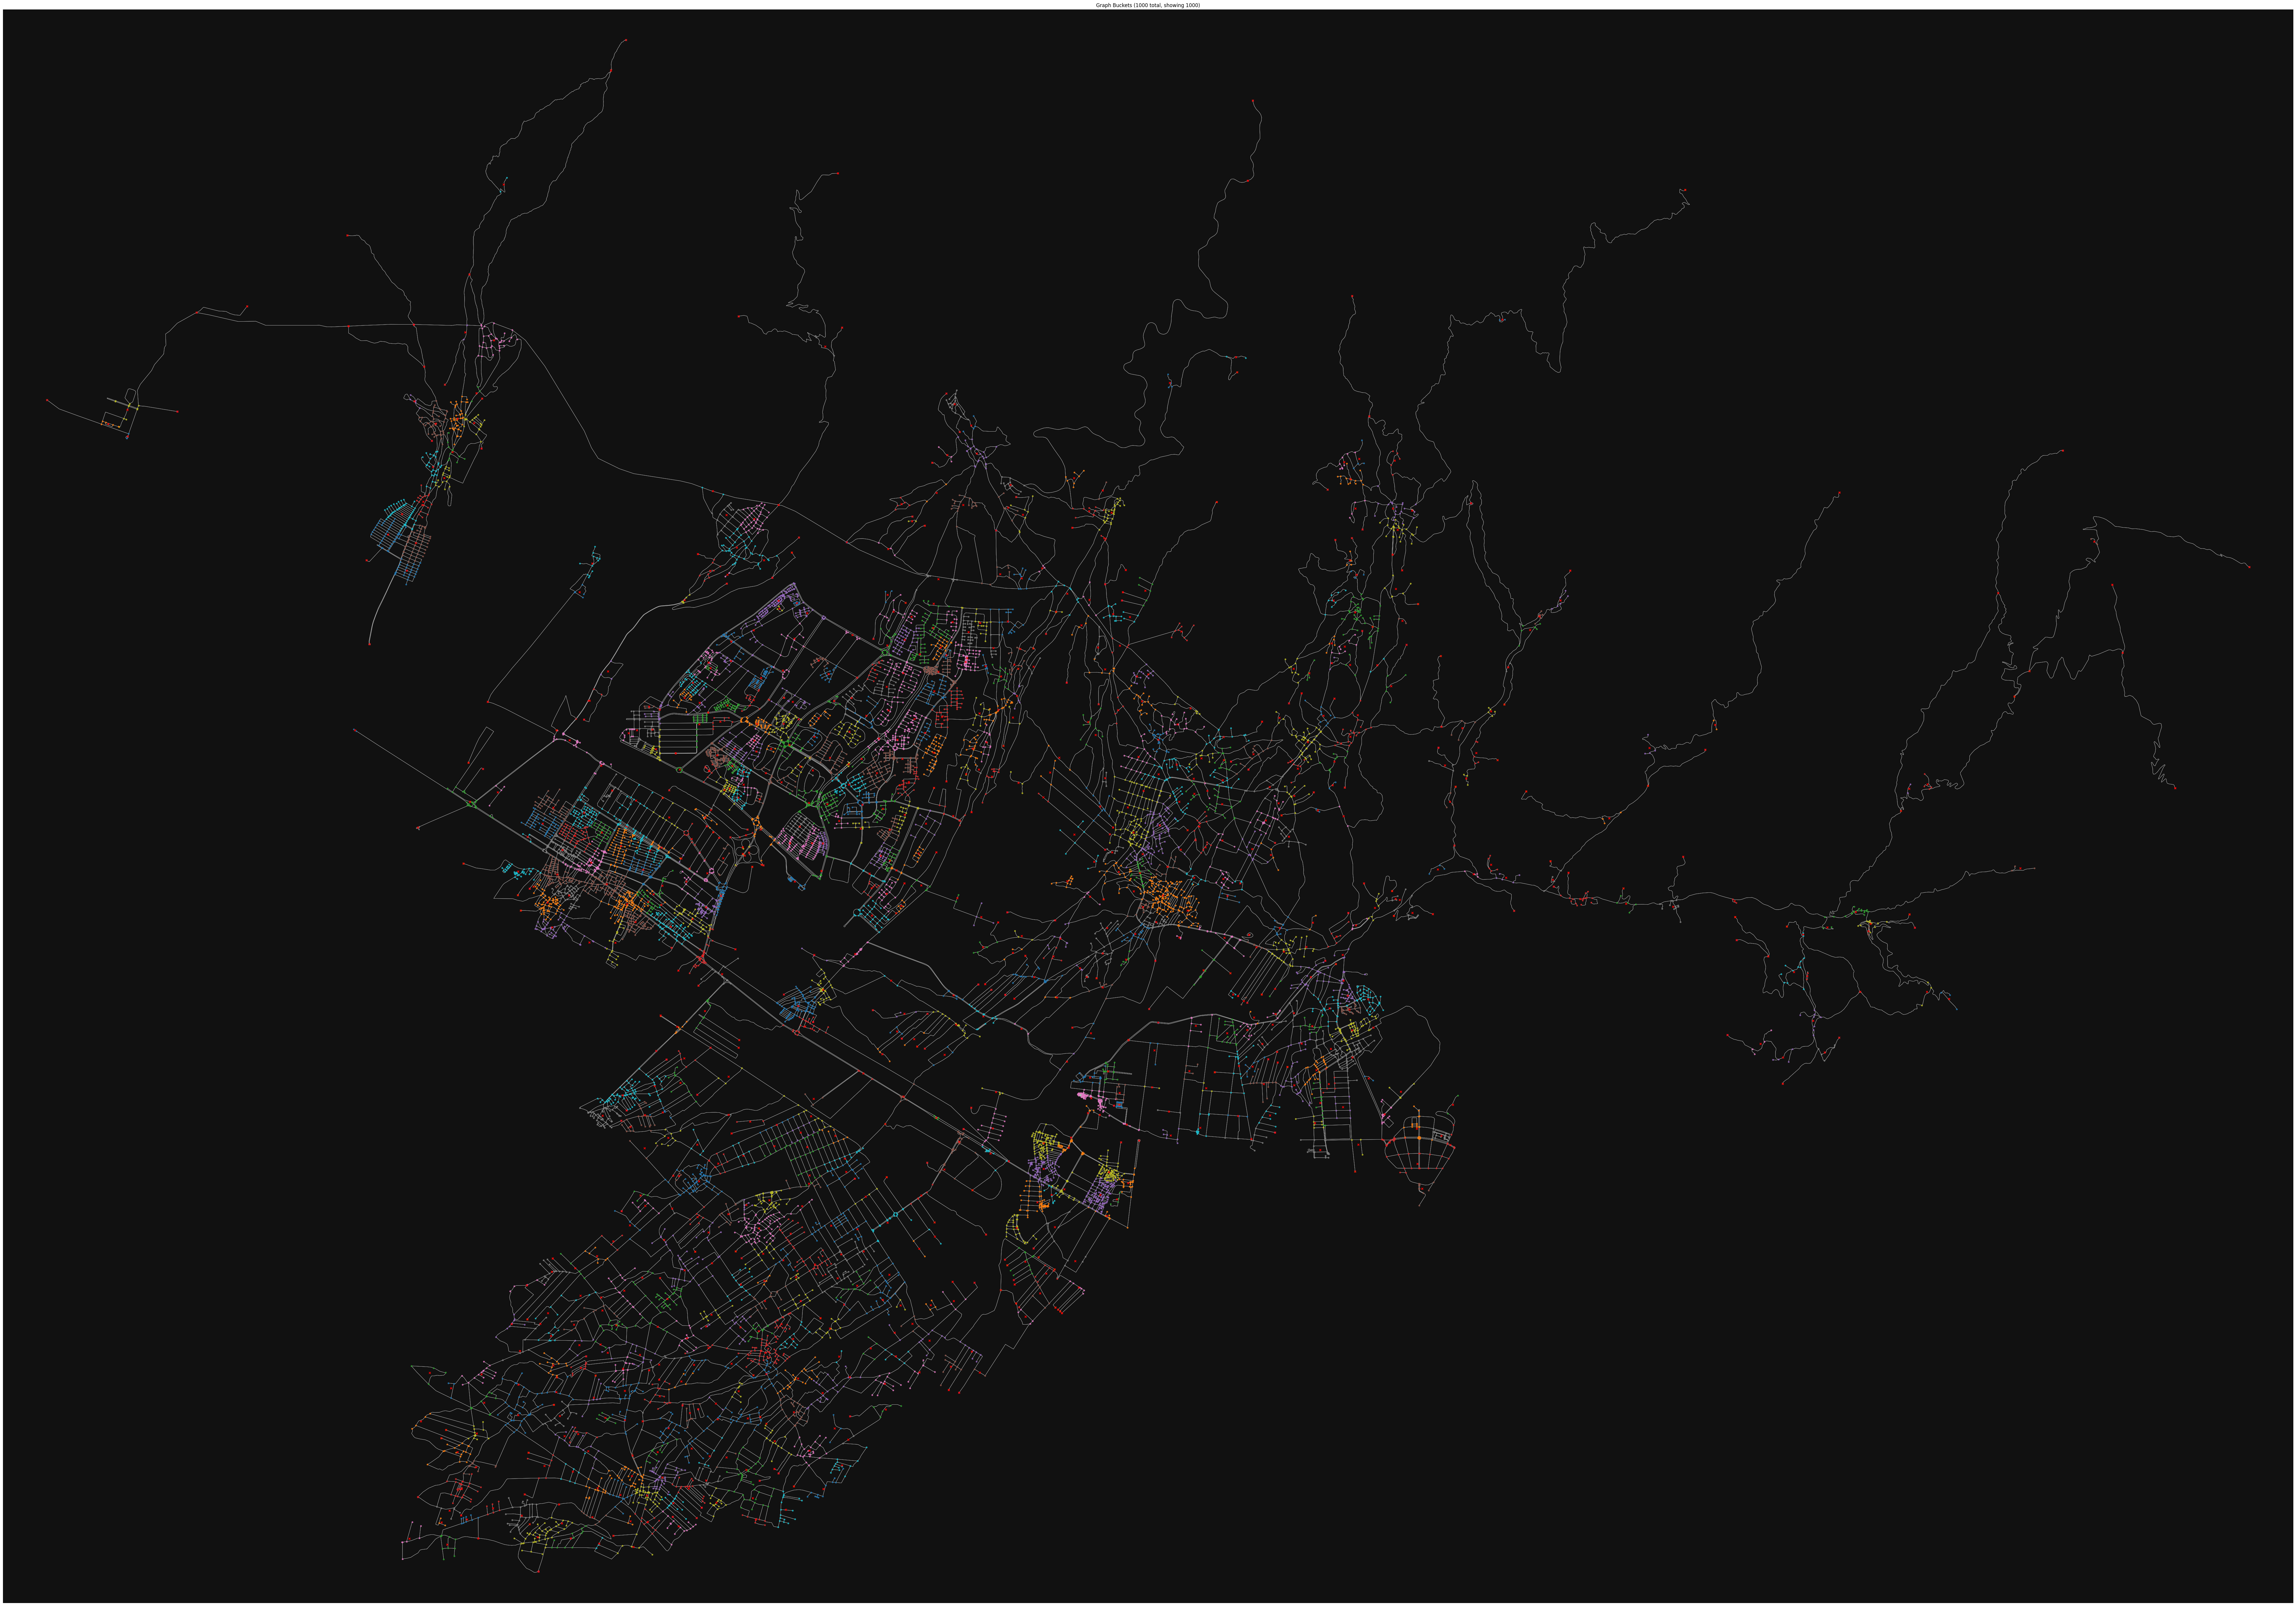

In [13]:
# Visualize (uncomment if you want to see the plot)
visualize_buckets(G, kmeans_buckets)

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from typing import List, Tuple
from dataclasses import dataclass
import osmnx as ox

@dataclass
class Bucket:
    id: int
    center_lat: float
    center_lon: float
    node_count: int
    nodes: List[int]
    bbox: Tuple[float, float, float, float]  # (min_lat, min_lon, max_lat, max_lon)

def visualize_buckets(
    G: nx.Graph,
    buckets: List[Bucket],
    save_path: str = './buckets.png',
    max_buckets_to_plot: int = 100,
    show_nodes: bool = True,
    show_bbox: bool = True
):
    # Set up base map
    fig, ax = ox.plot_graph(
        G,
        show=False,
        close=False,
        figsize=(20, 20),
        node_size=0,
        edge_color='lightgray',
        edge_linewidth=0.5
    )

    total_buckets = len(buckets)
    buckets_to_plot = buckets[:max_buckets_to_plot]

    # Cycle through colors
    colors = list(mcolors.TABLEAU_COLORS.values())
    while len(colors) < len(buckets_to_plot):
        colors += colors

    for i, bucket in enumerate(buckets_to_plot):
        color = colors[i]

        # Plot nodes
        if show_nodes:
            node_lats = [G.nodes[n]['y'] for n in bucket.nodes if n in G.nodes]
            node_lons = [G.nodes[n]['x'] for n in bucket.nodes if n in G.nodes]
            ax.scatter(node_lons, node_lats, c=color, s=10, alpha=0.8)

        # Plot center
        ax.scatter(
            bucket.center_lon,
            bucket.center_lat,
            c='red', s=30, marker='x', linewidths=2, zorder=3
        )

        # Plot bbox
        if show_bbox:
            min_lat, min_lon, max_lat, max_lon = bucket.bbox
            width = max_lon - min_lon
            height = max_lat - min_lat
            rect = Rectangle(
                (min_lon, min_lat), width, height,
                linewidth=2, edgecolor=color, facecolor='none', linestyle='--', zorder=2
            )
            ax.add_patch(rect)

    # Finalize
    plt.title(f"Visualized Buckets ({len(buckets_to_plot)} shown of {total_buckets})")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to: {save_path}")
    plt.show()


In [7]:
kmeans_buckets[2]

Bucket(id=2, center_lat=np.float64(35.91840918095238), center_lon=np.float64(50.80008037619047), node_count=21, nodes=[4703526779, 5999369618, 5999369621, 5999369623, 6833588351, 6833588356, 6833588357, 6833588358, 6833588489, 6833588513, 6833588514, 6833588517, 6833588522, 6833588525, 6833588528, 6833588530, 8685851693, 8685851696, 8685851698, 8685851699, 8685851700], bbox=(np.float64(35.9160355), np.float64(50.7939463), np.float64(35.9215084), np.float64(50.8044827)))

Plot saved to: ./buckets.png


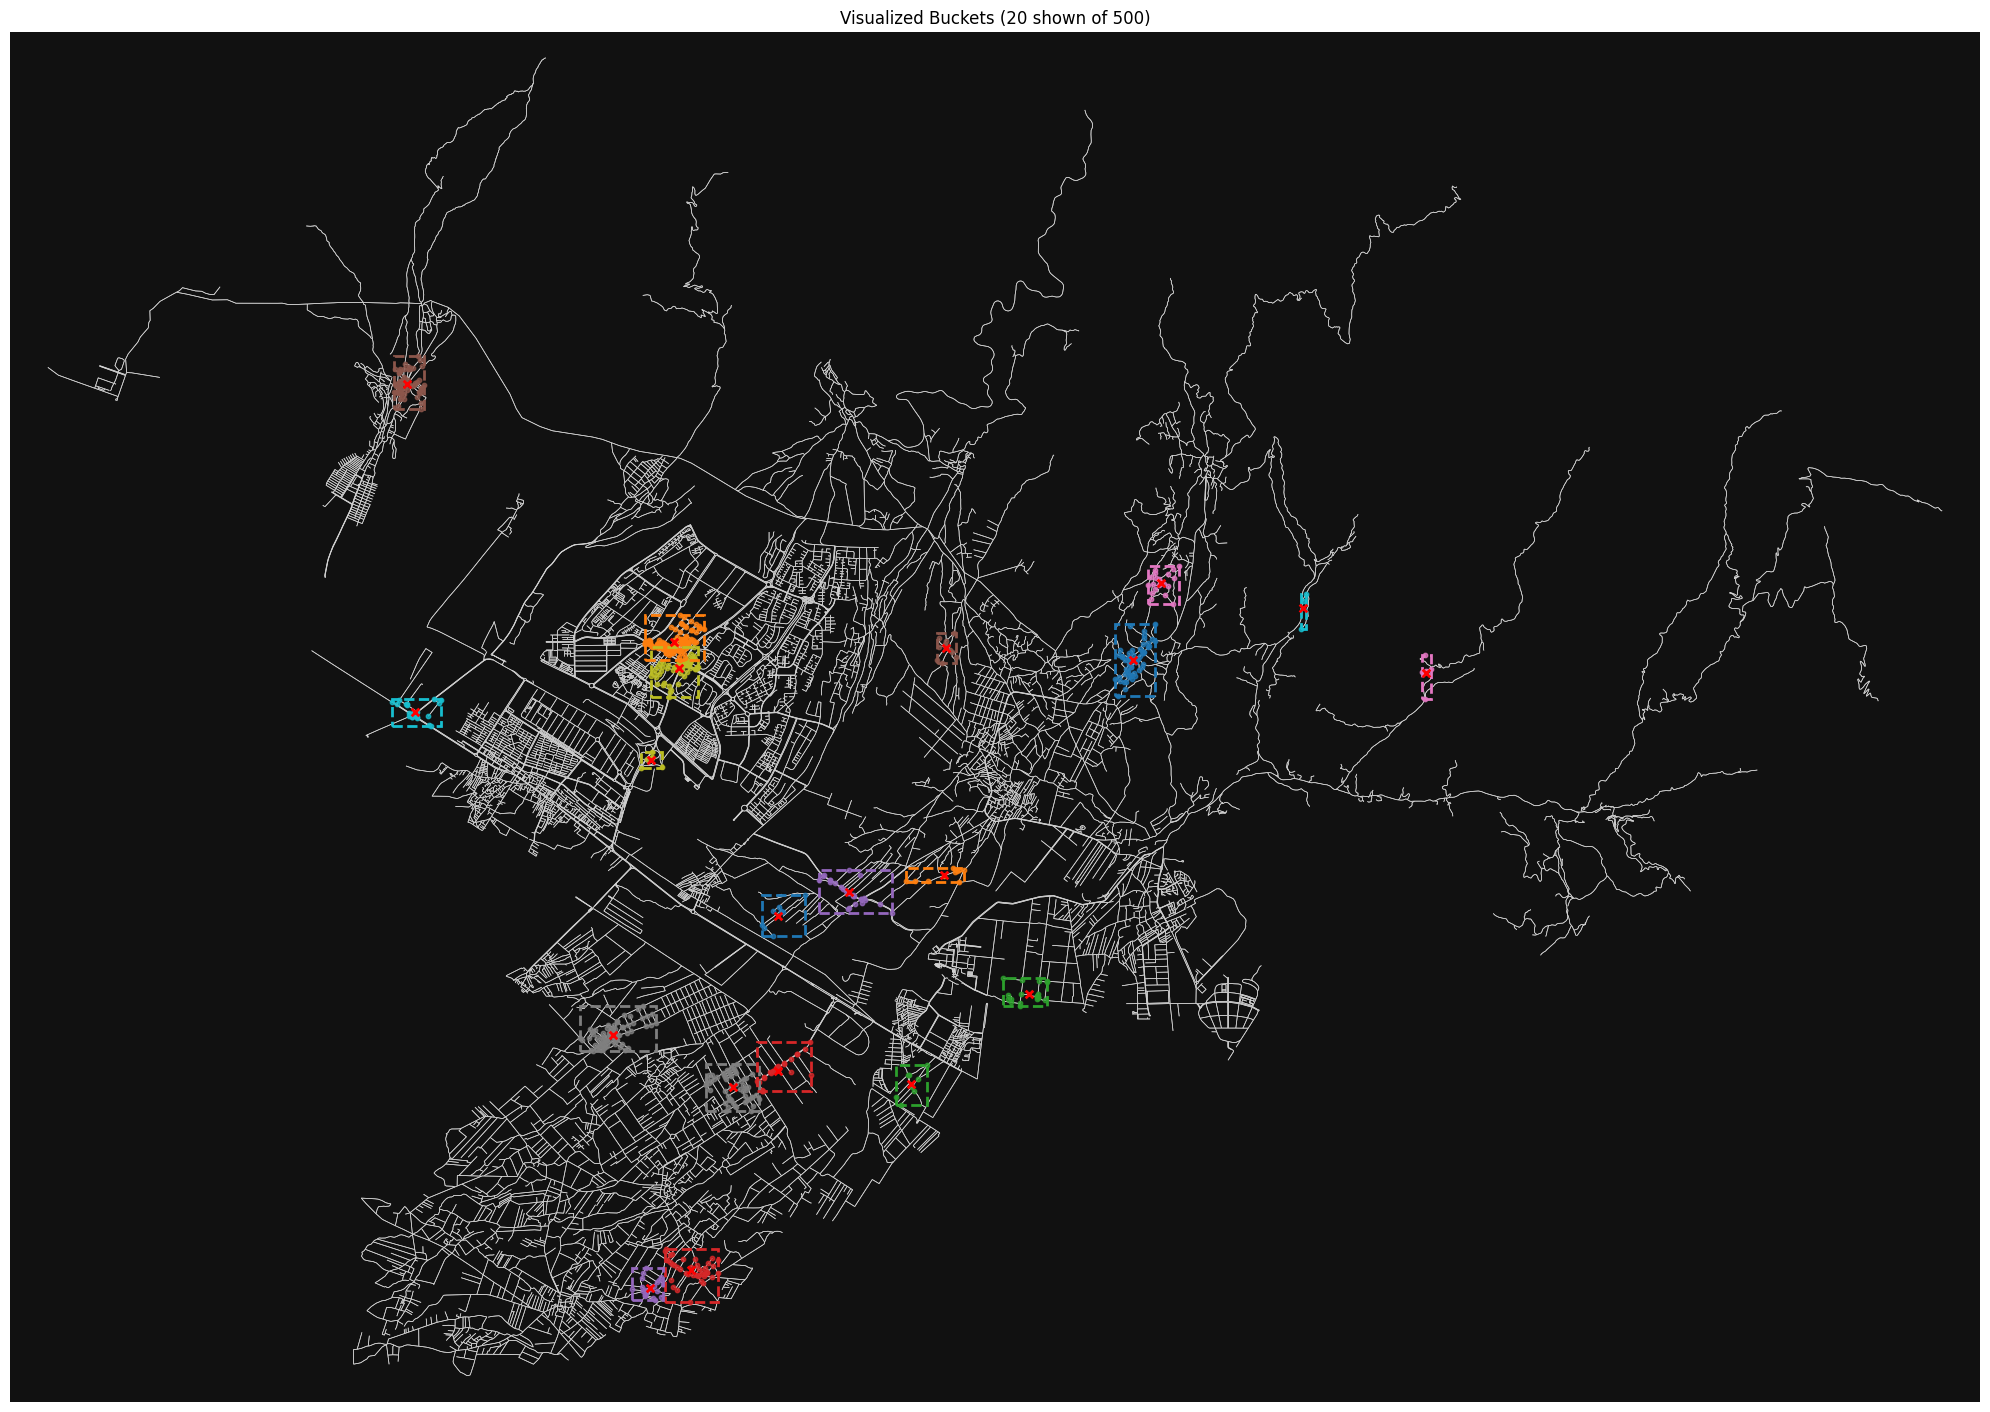

In [ ]:
place = "Savojbolagh County, Alborz Province, Iran"
G = ox.graph_from_place(place, network_type='walk')

visualize_buckets(G, kmeans_buckets, max_buckets_to_plot=20)

200


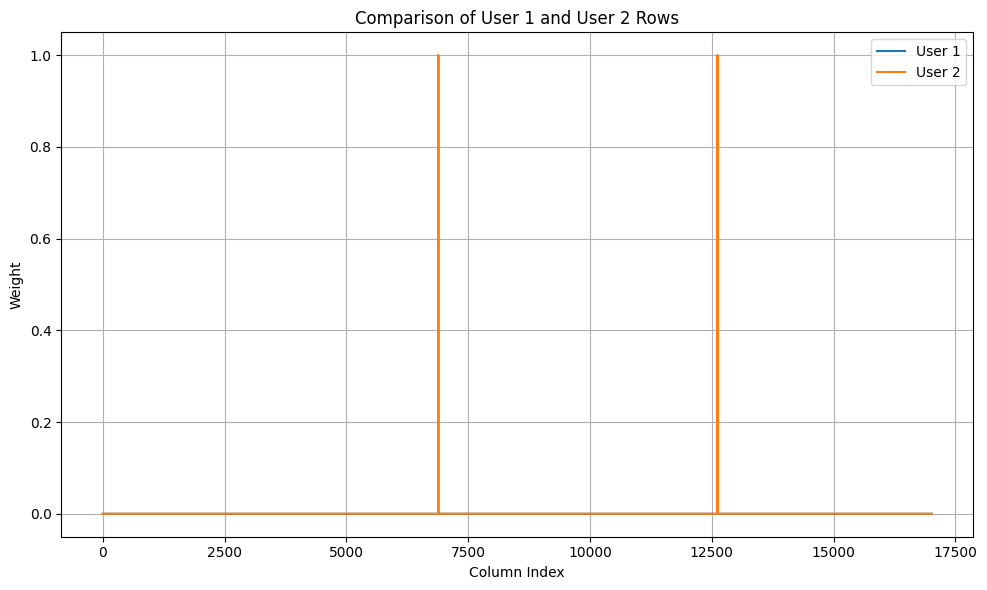

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved rows
rows = np.loadtxt("selected_rows.csv", delimiter=",")

# Plot both rows
plt.figure(figsize=(10, 6))
plt.plot(rows[0], label="User 1")   # first row
plt.plot(rows[1], label="User 2")   # second row

plt.xlabel("Column Index")
plt.ylabel("Weight")
plt.title("Comparison of User 1 and User 2 Rows")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
